In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [60]:
class Likelihood(nn.Module):
    def __init__(self):
        super().__init__()
        # Parameters for line
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Noise of data
        self.noise = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Collect losses over time
        self.losses = []
    
    def forward(self, x, y):
        # Takes numpy array as input and converts to tensors
        x = torch.tensor(x)
        y = torch.tensor(y)
        
        # Minimizing this function
        loss = torch.sum((y - x * self.m - self.b) ** 2 / (2 * self.noise ** 2)) + torch.log(self.noise)
        
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [61]:
class SimpleProb(nn.Module):
    def __init__(self):
        super().__init__()
        self.std = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Collects loss over time
        self.losses = []
    
    def forward(self, k):
        loss = torch.log(self.std) + 0.5 * (k / self.std) ** 2
    
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [62]:
class Posterior(nn.Module):
    def __init__(self):
        # All parameters that need optimization
        super().__init__()
        self.ll = Likelihood()
        self.pm = SimpleProb()
        self.pb = SimpleProb()
        
        # Collects loss over time
        self.losses = []
        self.reses = []
    
    def forward(self, x, y):
        loss = self.ll(x, y) + self.pm(self.ll.m) + self.pb(self.ll.b)
        self.reses.append((self.ll.m.item(), self.pm.std.item(), self.ll.b.item(), self.pb.std.item(), self.ll.noise.item()))
        
        # Save and return loss
        self.losses.append(loss.item())
        return loss
    

In [63]:
def train(model, x, y, epochs=5, frac=0.1):
    optimizer = optim.Adam(model.parameters())
    
    for epoch in tqdm(range(epochs), desc="Training..."):
        # Zero gradiant for training
        optimizer.zero_grad()
        
        # Random selection of data points per iteration
        #indices = np.random.randint(low=0, high=len(x), size=int(len(x) * frac))
        
        # Calculates likelihood
        #loglik = model(x[indices], y[indices])
        loglik = model(x, y)
        e = torch.mean(loglik)
        
        # Updates parameters
        e.backward()
        optimizer.step()
    
    return model

In [64]:
df = pd.read_csv('data/Advertising.csv').drop('Unnamed: 0', axis=1)
x = df.TV.to_numpy()
y = df.Sales.to_numpy()

In [65]:
model_ll = train(Likelihood(), x, y, epochs=5000)
model_ll

Training...: 100%|██████████| 5000/5000 [00:01<00:00, 2517.01it/s]


Likelihood()

In [66]:
(model_ll.m, model_ll.b, model_ll.noise)

(Parameter containing:
 tensor(0.0823, requires_grad=True),
 Parameter containing:
 tensor(0.2887, requires_grad=True),
 Parameter containing:
 tensor(1.4843, requires_grad=True))

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Likelihood Loss')]

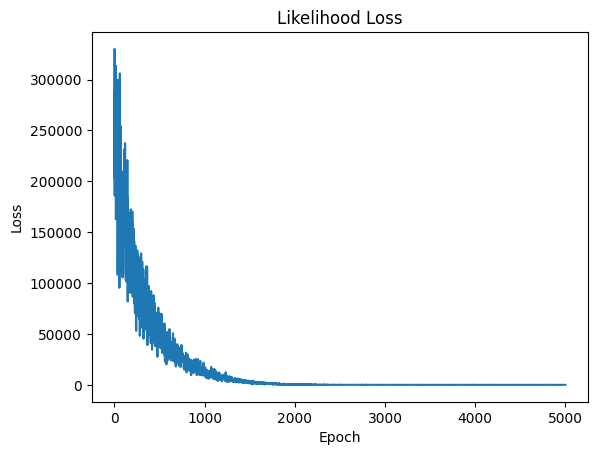

In [67]:
fig = sns.lineplot(x=range(len(model_ll.losses)), y=model_ll.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Likelihood Loss')

In [71]:
model_pl = train(Posterior(), x, y, epochs=5000)
model_pl

Training...: 100%|██████████| 5000/5000 [00:03<00:00, 1579.67it/s]


Posterior(
  (ll): Likelihood()
  (pm): SimpleProb()
  (pb): SimpleProb()
)

In [72]:
(model_pl.ll.m, model_pl.pm.std, model_pl.ll.b, model_pl.pb.std, model_pl.ll.noise)

(Parameter containing:
 tensor(0.0831, requires_grad=True),
 Parameter containing:
 tensor(0.0831, requires_grad=True),
 Parameter containing:
 tensor(0.1766, requires_grad=True),
 Parameter containing:
 tensor(0.1766, requires_grad=True),
 Parameter containing:
 tensor(1.4822, requires_grad=True))

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Posterior Loss')]

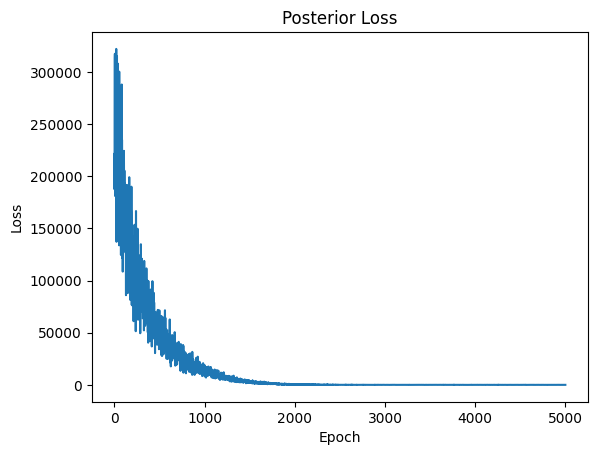

In [73]:
fig = sns.lineplot(x=range(len(model_ll.losses)), y=model_pl.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Posterior Loss')